# Amazon fine food review - sentimental analysis using KNN

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. 

# Overview

This Dataset contains 10 features/independent variables/predictors etc. We will look at the reviews of each and every customers and will analyze them using k-nearest neighbors algorithm for now and in next part we will apply algorithms like naive bayes, logistic regression, svm, decision tree etc.


<br>**Id** Row Id </br>
<br>**ProductId** Unique identifier for the product </br>
<br>**UserId** Unqiue identifier for the user</br>
<br>**ProfileName** Profile name of the user</br>
<br>**HelpfulnessNumerator** Number of users who found the review helpful</br>
<br>**HelpfulnessDenominator** Number of users who indicated whether they found the review helpful</br>
<br>**Score** Rating between 1 and 5</br>
<br>**Time** Timestamp for the review</br>
<br>**Summary** Brief summary of the review</br>
<br>**Text** Text of the review</br>

<br> **Objective** </br>

We should never forget our obective,  If foget, we may not reach to destination. So, here our objective is to predict whether a review is **-ve(Rating 1 or 2) or +ve(Rating 4 or 5 )**. let's get started...

# Table of Content

1.  Loading dataset
2.  Data Preprocessing()
3. Cross-Validation to find optimal K value
4. Apply KNN
    * KNN Model on Bow(bag of words)
    * KNN Model on TFIDF(2-gram) 
5. Score Prediction
6. Confusion Matrix 

In [3]:
# imported necessary libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection


In [6]:
con = sqlite3.connect('./database.sqlite')

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [7]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis
# Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:


In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep ='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'about', "weren't", 'these', "she's", 'further', 'themselves', 'down', "didn't", 'her', 'were', 'him', "isn't", 'that', 'being', 'as', 'be', 'ain', "shouldn't", 'when', 'then', 'his', 'but', 'me', 'hasn', 'shan', 'where', 'by', 'in', 'because', 'theirs', 'am', 'can', "hadn't", 'here', 'hers', 'aren', "shan't", 'does', 'some', 'above', 'why', 'each', 'only', 'has', 'more', 'for', 'below', "should've", 'doesn', 'before', 'd', 'needn', 'ma', 't', 'yours', 'under', 'wouldn', 'if', 'yourself', 'during', 'now', 'both', 'it', 'up', 'this', 'same', 'its', "mustn't", 'you', 'our', 'what', 'any', 'very', 'will', 'had', 'their', 'isn', 'from', 'don', 'yourselves', 'been', 'should', 'through', 'i', 'my', 'mightn', "won't", 'between', 'and', 'on', 'himself', 'whom', 'do', 'your', 'over', 'those', "aren't", 'once', "mightn't", 'myself', "needn't", "don't", "that'll", 'we', 'haven', 'again', 'mustn', "doesn't", 've', 'are', 'doing', "it's", 'at', "haven't", "you'll", 'herself', "wasn't", 'y', 'weren

In [17]:

i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [20]:
final['CleanedText']=final_string 

In [21]:
final.head(3)


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [22]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [23]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [24]:
cleaned_data.shape

(364171, 12)

In [40]:
data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n = 20000)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 20000)
final_40k = pd.concat([data_pos, data_neg])
final_40k.shape

(40000, 12)

In [41]:
# Sorting data based on time
final_40k["Time"] = pd.to_datetime(final_20k["Time"], unit = "s")
final_40k = final_40k.sort_values(by = "Time")

In [42]:
final_d=final_40k.sort_values(by='Time')
final_d.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
365,346040,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,negative,2002-12-27,Great movie turned bad,"Just to let you know, this movie is one of my ...",b'let know movi one person favorit ghost movi ...
488,121056,131233,B00004RAMX,A1PYZPS1QYR036,"Kazantzakis ""hinterlands""",5,8,negative,2003-10-29,Woodstream Gopher Trap 0610,This is a poor excuse for a gopher trap. I hav...,b'poor excus gopher trap lot gopher use trap r...
10440,222668,241459,B0001E5CJO,A1SO8AE23KZ0HZ,"Echo ""Echo""",4,4,positive,2004-07-17,"Dark, twisted, and underrated (just how I like...",As one of the few who caught this on cable in ...,b'one caught cabl earli attest disturb natur f...


In [43]:
X=final_d["CleanedText"]
X.shape

(40000,)

In [44]:
y=final_d["Score"]
y.shape

(40000,)

In [45]:
#split the data into train and test fo bag of words

X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=None)
#split train into cross val train and cross val test
X_t,X_cv,Y_t,Y_cv=train_test_split(X_train,Y_train,test_size=0.3)

In [46]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(28000,) (12000,) (28000,) (12000,)


# Bag of Words

In [48]:
#Bag of Words
BoW=CountVectorizer()
X_train=BoW.fit_transform(X_train)
#X_train=StandardScaler(with_mean=False).fit_transform(X_train)
x_test=BoW.transform(X_test)
#X_test=StandardScaler(with_mean=False).fit_transform(x_test)
print("the type of count vectorizer is:",type(X_train))
from sklearn import preprocessing
X_train=preprocessing.normalize(X_train)
X_test=preprocessing.normalize(x_test)
#X_test=StandardScaler(with_mean=False).fit_transform(x_test)

the type of count vectorizer is: <class 'scipy.sparse.csr.csr_matrix'>


In [49]:
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (28000, 21371)
Test Data Size:  (12000, 21371)


# Optimal K

In [50]:
#with either k=8 or 9 we get best accuracy for test to be 91%,now with 10 fold cross validation we have to see if our ccuracy improves
n_list=list(range(0,15))
neighb=list(filter(lambda x: x % 2 != 0, n_list))
#create a list of cross-val scores
scores_cv=[]
for k in neighb:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    scores=cross_val_score(knn,X_train,Y_train,cv=3,scoring='accuracy')
    scores_cv.append(scores.mean())

#Find misclassification error(i.e)how much data is misclassified

MSE=[1-x for x in scores_cv]

#find optimal k

optimal_k=neighb[MSE.index(min(MSE))]
print('\n the optimal k is %d.' % optimal_k)


 the optimal k is 13.


In [51]:
print("the type of count vectorizer is:",type(x_test))

the type of count vectorizer is: <class 'scipy.sparse.csr.csr_matrix'>


In [52]:
#KNN with optimal k and test accuracy for bag of words
from sklearn.neighbors import KNeighborsClassifier
knn_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm="brute")
#fit the model
knn_opt.fit(X_train,Y_train)
#predict the model
prediction=knn_opt.predict(x_test)

#the accuracy score
acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for bag of words model with optimal k=%d is %f%%' %(optimal_k,acc_score))


 the accuracy score for bag of words model with optimal k=13 is 74.741667%


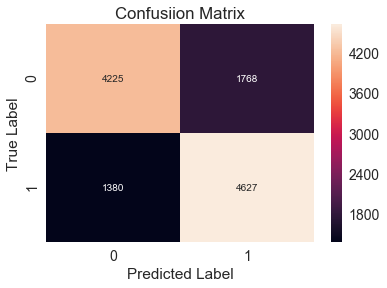

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matr_df = pd.DataFrame(confusion_matrix(Y_test, prediction), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df, annot=True,annot_kws={"size": 10}, fmt='g')
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [57]:
from sklearn.metrics import classification_report,precision_score,recall_score

print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75      5978
    positive       0.75      0.75      0.75      6022

   micro avg       0.75      0.75      0.75     12000
   macro avg       0.75      0.75      0.75     12000
weighted avg       0.75      0.75      0.75     12000



# TF-IDF KNN

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import metrics

In [63]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=0)
#split train into cross val train and cross val test
X_t,X_cv,Y_t,Y_cv=train_test_split(X_train,Y_train,test_size=0.3)

In [64]:
tf_idf_vect=TfidfVectorizer()
final_tfidf_vect=tf_idf_vect.fit_transform(X_train)
final_test_tfidf_vect=tf_idf_vect.transform(X_test)
from sklearn import preprocessing
X_train=preprocessing.normalize(final_tfidf_vect)
X_test=preprocessing.normalize(final_test_tfidf_vect)
final_tfidf_vect.get_shape(),final_test_tfidf_vect.get_shape()
print(X_train.shape,X_test.shape)

(28000, 21615) (12000, 21615)


In [65]:
X_train=final_tfidf_vect
X_test=final_test_tfidf_vect

In [66]:
Y_test.shape

(12000,)

# Optimal K

In [67]:
#for finding optimal k with odd list for neighbors
n_list=list(range(0,20))
neighb=list(filter(lambda x: x % 2 != 0, n_list))
#create a list of cross-val scores
scores_cv=[]
for k in neighb:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    scores=cross_val_score(knn,X_train,Y_train,cv=3,scoring='accuracy')
    scores_cv.append(scores.mean())

#Find misclassification error(i.e)how much data is misclassified

MSE=[1-x for x in scores_cv]

#find optimal k

optimal_k=neighb[MSE.index(min(MSE))]
print('\n the optimal k is %d.' % optimal_k)


 the optimal k is 19.


In [68]:
#KNN with optimal k and test accuracy for tf_idf model

knn_opt=KNeighborsClassifier(n_neighbors=optimal_k,algorithm="brute")
#fit the model
knn_opt.fit(X_train,Y_train)
#predict the model
prediction=knn_opt.predict(X_test)

#the accuracy score
acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for bag of words model with optimal k=%d is %f%%' %(optimal_k,acc_score))


 the accuracy score for bag of words model with optimal k=19 is 73.766667%


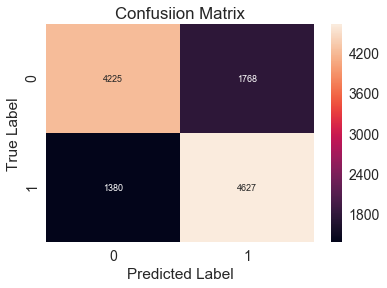

In [80]:
conf_matr_df = pd.DataFrame(confusion_matrix(Y_test, prediction), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df, annot=True,annot_kws={"size":9}, fmt='g')
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [70]:
from sklearn.metrics import classification_report,precision_score,recall_score

print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

    negative       0.75      0.70      0.73      5993
    positive       0.72      0.77      0.75      6007

   micro avg       0.74      0.74      0.74     12000
   macro avg       0.74      0.74      0.74     12000
weighted avg       0.74      0.74      0.74     12000



Observations

Recall(TPR) from the confusion matrix is: 73%
Precision=73%